In [55]:
import geopandas as gp
import matplotlib.pyplot as plt
from shapely.geometry import *
import pandas as pd
import numpy as np

1. Identify county
2. Assign water consumption to county
3. Fraction of population of a county in a place
4. Fraction of county water consumption to the place 
5. Assign location to place

In [56]:
# Final domestic demand dataframe
cols = ['state_alpha','state_code','place','place_code','county','county_code','place_pop','county_pop_frac','county_water_demand (m3/yr)','place_water_demand (m3/yr)','polygon','centroid']
domestic_demand = pd.DataFrame(columns = cols)

Read county->water demand file

Read county->place map file

Read place ->population  (Reading place and pop data from decennial_place_all to include CDP locations also)

Read county boundary shapefiles

In [66]:
county_water_demand = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Domestic/USGS_domestic_metric.csv')
county_place_map = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Domestic/Census Data/county_place_map.csv')
place_pop = pd.read_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Domestic\Census Data\place_pop_files\Decennial place files\decennial_place_all.csv')

# create variables to filter parameters - removed MD, MO-no demand data
contiguous_usa = ('AL','AZ','AR','CA','CO','CT','FL','GA','ID','IL',
                  'IA','KS','KY','LA','MI','MN','MS','MO','MD',
                  'MT','NE','NV','NJ','NM','NY','NC','ND','OH',
                  'OK','OR','PA','SC','SD','TX','UT','VA','WA',
                  'WV','WI','WY')


us_counties = gp.read_file(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\GeoData\US_County_Boundaries\US_CountyBndrys.shp')
us_counties = us_counties.to_crs("EPSG:4326")

In [68]:
# Drop non contiguous states
county_place_map_group = county_place_map.sort_values(['STATE','COUNTYNAME','PLACENAME']).groupby('STATE')
county_place_map_group = county_place_map_group.apply(pd.DataFrame).set_index('STATE')
for state in county_place_map_group.index.unique():
    if state in contiguous_usa:
        pass
    else:
        county_place_map_group.drop(index=state,inplace=True) 
county_place_map_group = county_place_map_group.reset_index()
# county_place_map_group = county_place_map_group.sort_values('COUNTYNAME')

In [69]:
county_place_map_group.to_csv(r'\Users\mhardika\Documents\AMO\Analysis Data Files\Domestic\county_place_map_group.csv')
# county_place_map_group = pd.read_csv

In [60]:
# # Remove rows were the place name ends with CDP
# idx_list = []
# for index,place in county_place_map_group.iterrows():
#     # if place['PLACENAME'][-3:] == 'CDP':
#         # print(place['PLACENAME'])
#     if place['CLASSFP']!='C1':
#         idx_list.append(index)

# county_place_map_group.drop(index=idx_list,inplace=True) 


In [70]:
# Organizing the decennial_place_all
# Some line items have more that ','
# Some places have the county name bracket

# Get the index of rows where theres more than 1 ','
idx_list= []
for index,row in place_pop.iterrows():
    if place_pop.loc[index]['NAME'].count(',') > 1:
        idx_list.append(index)

place_pop_weird = place_pop.loc[idx_list]
place_pop.drop(index=idx_list,inplace=True) 

# Create a dataframe with the rows with only 1 ','
place_pop_df = pd.DataFrame(columns=['place','state'])
place_pop_df[['place','state']] = place_pop['NAME'].str.split(", ",expand=True)
place_pop_df['pop'] = place_pop['Pop']

# # Create a dataframe with the rows with more than 1 ','
tmpDF2 = pd.DataFrame(columns=['place','state'])

for index,row in place_pop_weird.iterrows():
    temp = place_pop_weird.loc[index]['NAME'].split(", ")
    temp = [temp[0]+' '+ temp[1],temp[2]]
    temp = pd.DataFrame([temp],columns=['place','state'])
    tmpDF2= pd.concat([tmpDF2,temp])
    tmpDF2.reset_index()    
tmpDF2['pop'] = place_pop_weird['Pop']

place_pop_df = pd.concat([place_pop_df,tmpDF2])

# Dropping duplicate rows
place_pop_df = place_pop_df.drop_duplicates()

# Get list of rows where the county name is mentioned in brackets
idx_list= []
for index,row in place_pop_df.iterrows():
    if 'County)' in place_pop_df.loc[index]['place']:
        idx_list.append(index)

county_name_list = []
place_name_list =[]
# Go through the dataframe again, if the index is in the idx_list, update county column with name, otherwise county column with blank
for index,row in place_pop_df.iterrows():
    if index in idx_list:
        # Split the place name and county name
        temp_place_list = row['place'].split(" (")
        county_name = temp_place_list[1].split(")")[0]
        # Add county name to list
        county_name_list.append(county_name)
        # Update place name
        place_name_list.append(temp_place_list[0])
    else:
        county_name_list.append('')
        place_name_list.append(row['place'])

place_pop_df['place'] = place_name_list
place_pop_df['county'] = county_name_list

# map state name to state code
path = 'C:/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/data'
df = place_pop_df
state_abbv_df = pd.read_csv(path + '/state_abbv.csv', index_col='us_state')

df['state_alpha'] = df['state'].map(state_abbv_df.abbv)
# state_abbv_df
place_pop_df= df


In [63]:
place_pop_df.head(5)

,place,state,pop,county,state_alpha
0,Abanda CDP,Alabama,133,,AL
1,Abbeville city,Alabama,2358,,AL
2,Adamsville city,Alabama,4366,,AL
3,Addison town,Alabama,659,,AL
4,Akron town,Alabama,225,,AL


In [72]:
place_pop_df.to_csv(r'\Users\mhardika\Documents\AMO\Analysis Data Files\Domestic\place_pop_df.csv')

Map county->place->state->population

In [ ]:
# example = 'check (check county)'
# test = example.split(" (")
# test2 = test[1].split(")")[0]
# print(test,'\n')
# print('gap')
# print(test2)

len(place_pop_df[(place_pop_df['state_alpha']=='AL') & (place_pop_df['place']=='Mount Olive CDP')]['pop'].unique())

2

In [74]:
# Add every state-county-place population data
# If a place is in two counties, the population is divided for each county
domestic_demand = pd.DataFrame(columns = cols)
# for state in county_place_map_group.STATE.unique():
for state in ['NM']:
    print(state)
    place_list = []
    # Multiple counties may have the same place
    state_code = county_place_map_group[county_place_map_group.STATE == state]['STATEFP'].values[0]
    for county in county_place_map_group[county_place_map_group.STATE == state].COUNTYNAME.unique():
        try:
            county_water_demand_var = county_water_demand[(county_water_demand.STATE==state)&(county_water_demand.COUNTY==county)]['DO-WFrTo'].values[0]
        except IndexError:
            print(county,county_water_demand[(county_water_demand.STATE==state)&(county_water_demand.COUNTY==county)]['DO-WFrTo'])
        i=0
        for place in county_place_map_group[(county_place_map_group.STATE == state)  & (county_place_map_group.COUNTYNAME == county)].PLACENAME:
            # Check if the place is included in the place-population dataframe
            if place in place_pop_df[place_pop_df['state_alpha']==state]['place'].values:
                if len(place_pop_df[(place_pop_df['state_alpha']==state) & (place_pop_df['place']==place)]['pop'].unique())>1:
                    if place in place_list: 
                        # print(place)
                        i = place_list.count(place)-1+1
                        num = float(place_pop_df[(place_pop_df['state_alpha']==state) & (place_pop_df['place']==place)]['pop'].unique()[i])
                        # print(county,place,i,place_pop_df[(place_pop_df['state_alpha']==state) & (place_pop_df['place']==place)]['pop'].unique()[i])
                    else: 
                        num = float(place_pop_df[(place_pop_df['state_alpha']==state) & (place_pop_df['place']==place)]['pop'].unique()[0])
                        # print(county,place,0,place_pop_df[(place_pop_df['state_alpha']==state) & (place_pop_df['place']==place)]['pop'].unique()[0])
                    place_list.append(place)
                else:
                    num = float(place_pop_df[(place_pop_df['state_alpha']==state) & (place_pop_df['place']==place)]['pop'].unique()[0])/len(county_place_map_group[(county_place_map_group['STATE']==state) & (county_place_map_group['PLACENAME']==place)])
                    # print('Splitting place population')
                    # print(place,len(county_place_map_group[(county_place_map_group['STATE']==state) & (county_place_map_group['PLACENAME']==place)]))
                temp = {'state_alpha':state,
                        'state_code':state_code,
                        'place':place,
                        'place_code':county_place_map_group[(county_place_map_group.STATE == state) & (county_place_map_group.PLACENAME == place) & (county_place_map_group.COUNTYNAME == county)]['PLACEFP'].values[0],
                        'county':county,
                        'county_code':county_place_map_group[(county_place_map_group.STATE == state) & (county_place_map_group.PLACENAME == place) & (county_place_map_group.COUNTYNAME == county)]['COUNTYFP'].values[0],
                        'place_pop': num,
                        'county_pop_frac':0, 
                        'county_water_demand (m3/yr)':county_water_demand_var,
                        'place_water_demand (m3/yr)':0,
                        'polygon':0,
                        'centroid':0,               
                        }
                
                temp = pd.DataFrame([temp])
                domestic_demand= pd.concat([domestic_demand,temp])
                domestic_demand.reset_index()
                
# temp
domestic_demand.head(2)

NM
Bernalillo County San Antonito CDP 0 989.0
Cibola County Mountain View CDP 0 56.0
Dona Ana County Placitas CDP 0 488.0
Luna County Mountain View CDP 1 134.0
Rio Arriba County La Madera CDP 0 140.0
Rio Arriba County San Jose CDP 0 670.0
San Miguel County San Jose CDP 1 67.0
Sandoval County La Cueva CDP 0 176.0
Sandoval County La Madera CDP 1 729.0
Sandoval County Placitas CDP 1 5041.0
Sandoval County Torreon CDP 0 281.0
Santa Fe County Arroyo Hondo CDP 0 331.0
Santa Fe County La Cueva CDP 1 473.0
Santa Fe County Valencia CDP 0 115.0
Socorro County San Antonito CDP 1 81.0
Taos County Arroyo Hondo CDP 1 428.0
Torrance County Torreon CDP 1 167.0
Valencia County Valencia CDP 1 2052.0


,state_alpha,state_code,place,place_code,county,county_code,place_pop,county_pop_frac,county_water_demand (m3/yr),place_water_demand (m3/yr),polygon,centroid
0,NM,35,Albuquerque city,2000,Bernalillo County,1,564559.0,0,1616560.423,0,0,0
0,NM,35,Barton CDP,6220,Bernalillo County,1,641.0,0,1616560.423,0,0,0


In [75]:
# Add place wise population fraction and water demand

for state in domestic_demand.state_alpha.unique():
    for county in county_place_map_group[county_place_map_group.STATE == state].COUNTYNAME.unique():
        frac = domestic_demand[(domestic_demand.state_alpha == state) & (domestic_demand.county == county) ]['place_pop']/sum(domestic_demand[(domestic_demand.state_alpha == state) & (domestic_demand.county == county) ]['place_pop'])

        domestic_demand.loc[(domestic_demand.state_alpha == state) & (domestic_demand.county == county) ,'county_pop_frac'] = frac

domestic_demand['place_water_demand (m3/yr)'] = domestic_demand['county_pop_frac']*domestic_demand['county_water_demand (m3/yr)']

# domestic_demand

Map state->place->polygon+centroid

In [76]:
# Read file based on state code and find location based on place for each county

location_file_path = '/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Domestic/Census Data/place_location_files/'

domestic_demand['place_code'] = domestic_demand['place_code'].astype('int64')

for state_code in domestic_demand.state_code.unique():
    file_name = 'tl_rd22_' + str(f'{state_code:02d}') + '_place'
    file_path = location_file_path + file_name + '/' + file_name +'.shp'
    df = gp.read_file(file_path)
    df = df.to_crs("EPSG:4326")
    df['PLACEFP'] = df['PLACEFP'].astype(int)
    df = df.set_index('PLACEFP')
    
    domestic_demand.loc[domestic_demand.state_code == state_code,'polygon'] = domestic_demand[domestic_demand.state_code == state_code]['place_code'].map(df.geometry)
    
    # for place_code in domestic_demand[domestic_demand.state_code == state_code].place_code:
    #     domestic_demand.loc[(domestic_demand.state_code == state_code) & (domestic_demand.place_code == place_code),'polygon']  = df[(df.STATEFP == str(state_code)) & (df.PLACEFP== str(place_code))].geometry

domestic_demand.centroid = domestic_demand.polygon.values.centroid.to_crs("EPSG:4326")
# domestic_demand

c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\IPython\core\interactiveshell.py:3382: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if await self.run_code(code, result, async_=asy):


In [ ]:
# domestic_demand.to_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Domestic/Census Data/sample_analysis/state_demand_location.csv',
#                        columns=['state_alpha','state_code','place','place_code','county','county_code','place_pop','county_pop_frac','county_water_demand (m3/yr)','place_water_demand (m3/yr)'])

<AxesSubplot: >

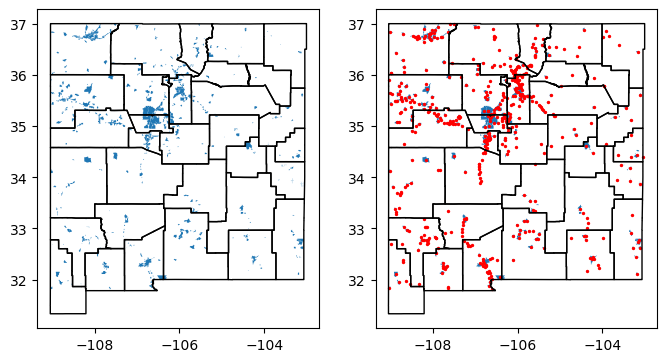

In [77]:
state_code = f'{domestic_demand.state_code.unique()[0]:02d}'
state = us_counties.loc[us_counties['STATEFP']==state_code]

state_place = gp.read_file('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Domestic/Census Data/place_location_files/tl_rd22_'+state_code+'_place/tl_rd22_'+state_code+'_place.shp' )
state_place = state_place.to_crs("EPSG:4326")

fig, (ax,ax2) = plt.subplots(1,2,figsize=(8,8))

# All places
state_place.plot(ax=ax, markersize = 5,label='PP')
state.plot(ax=ax,figsize=(50, 50),facecolor ='none',edgecolor ='black')

# # Places available in the census data for places
# places = gp.GeoSeries(domestic_demand.polygon)
# places.plot(ax=ax1, color='blue', markersize = 5,label='PP')
# az.plot(ax=ax1,figsize=(50, 50),facecolor ='none',edgecolor ='black')

# Centroid of population data for places 
state_place.plot(ax=ax2, markersize = 5,label='PP')
centroids = gp.GeoSeries(domestic_demand.centroid.values)
centroids.plot(ax=ax2, color='red', markersize = 2,label='PP')
state.plot(ax=ax2,figsize=(50, 50),facecolor ='none',edgecolor ='black')


Comparison of county census population vs total city+town population

In [ ]:
df = pd.read_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Domestic\Census Data\co-est2022-alldata.csv')
df1 = df[(df['STATE']==float(state_code)) & (df['COUNTY']!=0)].groupby('CTYNAME').first()

66.05477801040752


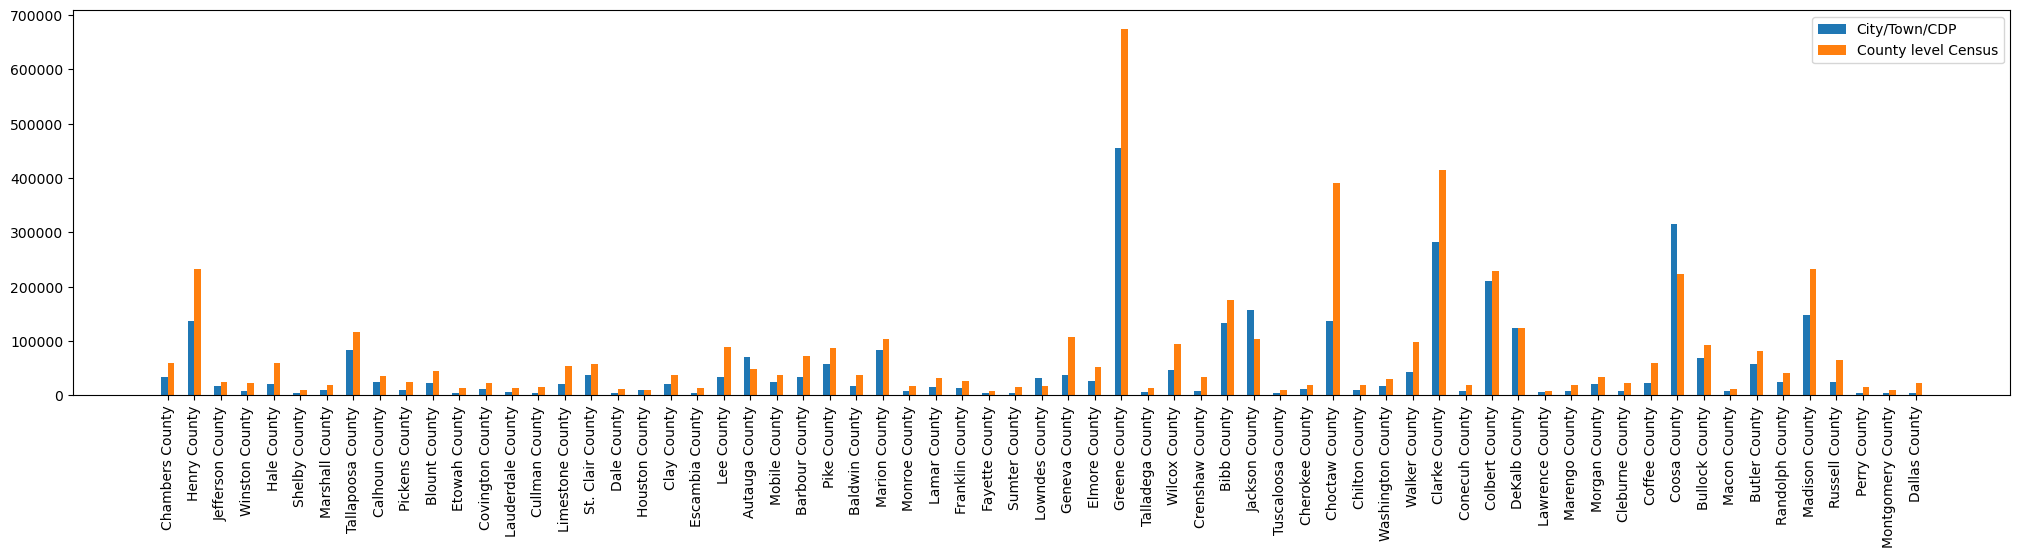

In [ ]:
county_pop_calc = pd.DataFrame(columns = ['county','population'])
county_list = domestic_demand.county.unique()

for county in county_list:
    temp = {'county': county,
            'population':domestic_demand[domestic_demand['county']==county]['place_pop'].sum()}

    temp = pd.DataFrame([temp])
    county_pop_calc= pd.concat([county_pop_calc,temp])

county_pop_calc.reset_index()
county_pop_calc= county_pop_calc.sort_values(by=['county'])


fig,ax = plt.subplots(figsize=(25,5))
x = np.array(range(0,len(county_list)))

ax.bar(x-0.125, county_pop_calc['population'], width = 0.25,label='City/Town/CDP')
ax.bar(x+0.125, df1.sort_values(by=['CTYNAME'])['POPESTIMATE2020'], width = 0.25, label = 'County level Census')
ax.legend()

ax.set_xticks(range(0,len(county_list)),county_list,rotation = 90)

frac = sum(county_pop_calc['population'])/sum(df1['POPESTIMATE2020'])
print(frac*100)